In [2]:
from re import S
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Carga de datos

In [4]:
df = pd.read_csv('close_normalized_prices.csv')
df['X'] = df['X'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))
df['Y'] = df['Y'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

# Division train-test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df.X.to_numpy()).astype(np.float32),
                                                    np.stack(df.Y.to_numpy()).astype(np.float32),
                                                    test_size=0.25,
                                                    random_state=42)

# Conversión a tensores

In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, seq_length)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, seq_length)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Dataloaders

In [7]:
# Crear DataLoaders
batch_size = 100
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modelo

In [9]:
class CNN_LSTM(nn.Module):

  def __init__(self):
    super(CNN_LSTM, self).__init__()
    # Capa Conv1D para extracción de características espaciales
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=1)

    # Batch normalization
    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(256)

    # Max Pool
    self.pool = nn.MaxPool1d(kernel_size=2)

    # Dropout
    self.dropout_layer = nn.Dropout(p=0.15)

    # ReLu
    self.relu = nn.ReLU()

    # Capa LSTM
    self.lstm = nn.LSTM(input_size=256, hidden_size=64, num_layers=3, batch_first=True)

    # Capa Fully Connected
    self.fc1 = nn.Linear(64, 32)  # Predecir 5 valores
    self.fc2 = nn.Linear(32, 16)  # Predecir un solo valor
    self.fc3 = nn.Linear(16, 5)  # Predecir un solo valor

    # Inicialización de pesos
    self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self, x):
    # Primer capa completa
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool(x)

    # Segunda capa completa
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Tercera capa completa
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Reordenar datos
    # Antes batch, channels, seq_length
    x = x.permute(0, 2, 1)
    # Después batch, seq_length, features

    # Capas LSTM
    x, _ = self.lstm(x)

    # Se toma la ultima salida de secuencia, que es la representación de la serie
    x = x[:, -1, :]

    # Capas Fully Connected
    x = self.dropout_layer(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout_layer(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout_layer(x)
    x = self.fc3(x)

    return x

# Función de perdida propia

In [10]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse = torch.mean(((y_pred - y_true)*100) ** 2)
        return mse

# Train model

Epoch 1/150, Loss: 1075.956070, 32.801769
Epoch 2/150, Loss: 1014.380413, 31.849339
Epoch 3/150, Loss: 996.035081, 31.560023
Epoch 4/150, Loss: 980.949917, 31.320120
Epoch 5/150, Loss: 965.900108, 31.078934
Epoch 6/150, Loss: 950.620649, 30.832137
Epoch 7/150, Loss: 935.516352, 30.586212
Epoch 8/150, Loss: 919.497490, 30.323217
Epoch 9/150, Loss: 902.999489, 30.049950
Epoch 10/150, Loss: 888.420762, 29.806388
Epoch 11/150, Loss: 872.761395, 29.542535
Epoch 12/150, Loss: 857.859264, 29.289235
Epoch 13/150, Loss: 843.595257, 29.044711
Epoch 14/150, Loss: 828.275294, 28.779772
Epoch 15/150, Loss: 815.347267, 28.554286
Epoch 16/150, Loss: 803.747431, 28.350440
Epoch 17/150, Loss: 790.398781, 28.114032
Epoch 18/150, Loss: 779.530951, 27.920081
Epoch 19/150, Loss: 767.889022, 27.710811
Epoch 20/150, Loss: 758.146597, 27.534462
Epoch 21/150, Loss: 750.681334, 27.398564
Epoch 22/150, Loss: 741.454107, 27.229655
Epoch 23/150, Loss: 732.815969, 27.070574
Epoch 24/150, Loss: 725.238723, 26.930257

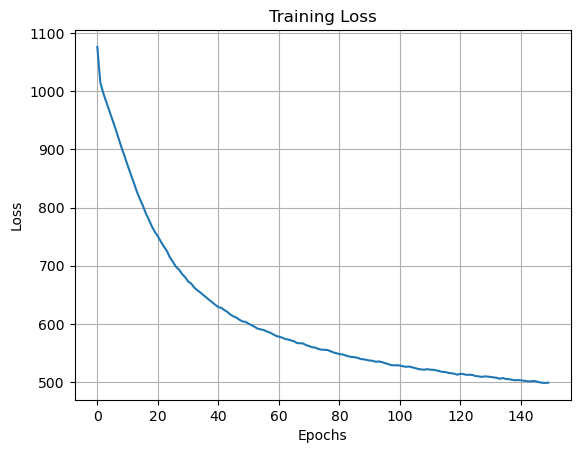

In [11]:
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 150
losses = list()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
    losses.append(train_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.6f}, {math.sqrt(train_loss):.6f}")

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [12]:
model.eval()
predictions = []
actuals = []

# Score en test
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_test = np.concatenate(predictions).reshape(-1, 5)
actuals_test = np.concatenate(actuals).reshape(-1, 5)

# Score en train
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_train = np.concatenate(predictions).reshape(-1, 5)
actuals_train = np.concatenate(actuals).reshape(-1, 5)

In [13]:
print("Evaluación del modelo:")
print("MAE Train:", np.mean(np.abs(predictions_train - actuals_train)),
      "MAE Test:", np.mean(np.abs(predictions_test - actuals_test)))
print("MSE Train:", np.mean((predictions_train - actuals_train) ** 2),
      "MSE Test:", np.mean((predictions_test - actuals_test) ** 2))
print("RMSE Train:", np.sqrt(np.mean((predictions_train - actuals_train) ** 2)),
      "RMSE Test:", np.sqrt(np.mean((predictions_test - actuals_test) ** 2)))

Evaluación del modelo:
MAE Train: 0.16962662 MAE Test: 0.22214572
MSE Train: 0.05910387 MSE Test: 0.108236544
RMSE Train: 0.24311288 RMSE Test: 0.32899323


**V1 eval (20 epochs)**

Evaluación del modelo:

MAE Train: 0.19001389 MAE Test: 0.20664866

MSE Train: 0.07552329 MSE Test: 0.09422373

RMSE Train: 0.274815 RMSE Test: 0.30695885

**V1 eval (50 epochs)**

Evaluación del modelo:

MAE Train: 0.1813991 MAE Test: 0.21548034

MSE Train: 0.06661031 MSE Test: 0.10138324

RMSE Train: 0.25808972 RMSE Test: 0.31840736

**V1 eval (150 epochs)**

MAE Train: 0.16962662 MAE Test: 0.22214572

MSE Train: 0.05910387 MSE Test: 0.108236544

RMSE Train: 0.24311288 RMSE Test: 0.32899323

In [14]:
torch.save(model.state_dict(), "../weights/cnn_lstm_v1_weights_3.pth")
torch.save(model, "../models/cnn_lstm_v1_model_3.pth")